This notebook was used to obtain the Figure 11.

It modifies the code of the previous notebooks to obtain the dispersion relation.

In [ ]:
%pip install pennylane
%pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 36.8 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import pennylane as qml
import pennylane.numpy as np

Functions to prepare the state and evolve it in the imaginary time.

In [ ]:
#Trotter for Ising
sigma_z = np.array([[1.0, 0.0], [0.0, -1.0]])
sigma_x = np.array([[0.0, 1.0], [1.0, 0.0]])
sigma_y = np.array([[0.0, -1j], [1j, 0.0]])
W = np.array([[1.0, -1j], [1.0, 1j]])/np.sqrt(2.)

def Ising_U(dt, J, h):
  """
  Returns the unitary matrix for the Ising Trotterization.

  Args:
    dt (np.float): Trotter time step;
    J (np.float) : the coefficient of the interaction term in the Ising Hamiltonian.
    h (np.float) : the coefficient of the transverse magnetic field term.

  Returns:
     U - unitary matrix used in Trotter evolution on two neighbour sites.
  """
  H = -J*np.einsum("ij, kl -> ikjl", sigma_z, sigma_z)
  H -= h*np.einsum("ij, kl -> ikjl", sigma_x, np.eye(2))/2
  H -= h*np.einsum("ij, kl -> ikjl", np.eye(2), sigma_x)/2
  H = np.reshape(H, [4,4])
  d, V = np.linalg.eigh(H)
  U = np.einsum("ij, j, kj -> ik", V, np.exp(-1j*dt*d), V)
  return U

def Trotter_Ising(dt, J, h, wqubits):
  """
  Applies Trotterized evolution with Ising Hamiltonian in real time.
  Note, that wqubits should be even.

  Args:
    dt (np.float): Trotter time step;
    J (np.float) : the coefficient of the interaction term in the Ising Hamiltonian.
    h (np.float) : the coefficient of the transverse magnetic field term in X direction.
    wqubits (np.int) : number of physical (without ancilla) qubits

  """
  N = wqubits//2
  U = Ising_U(dt, J, h)
  for q in range(N):
    qml.QubitUnitary(U, wires = [2*q,2*q+1])
  for q in range(N-1):
    qml.QubitUnitary(U, wires = [2*q+1,2*q+2])
  qml.QubitUnitary(U, wires = [wqubits-1, 0])


@qml.defer_measurements
def imaginary_time_step_Ising(dt, J, h, nqubits, theta0):
  """
  Applies one step of Trotterized evolution with Ising Hamiltonian in imaginery time.
  Note, that nqubits should be odd.

  Args:
    dt (np.float): Trotter time step of real time evolution;
    J (np.float) : the coefficient of the interaction term in the Ising Hamiltonian.
    h (np.float) : the coefficient of the transverse magnetic field term in X direction.
    nqubits (np.int): total number of qubits, both physical and one (last) ancilla qubit.
    theta0 (np.float): the angle of the Rz gate, as defined in arXiv:2111.12471
  """
  wqubits = nqubits - 1
  qml.Hadamard(wires = [nqubits-1])
  qml.QubitUnitary(W, wires = [nqubits-1])
  qml.ctrl(Trotter_Ising, [nqubits-1], control_values = [0])(dt, J, h, wqubits)
  qml.ctrl(qml.adjoint(Trotter_Ising), [nqubits-1], control_values = [1])(dt, J, h, wqubits)
  qml.RZ(-2*theta0, wires = [nqubits-1])
  qml.adjoint(qml.QubitUnitary(W, wires = [nqubits-1]))
  qml.measure(wires = [nqubits-1], postselect = 0)

def imaginary_time_evolution_Ising(steps, m0, J, h, nqubits):
  """
  Applies Trotterized evolution with Ising Hamiltonian in imaginery time.
  steps controls the Trotter time steps.
  Note, that nqubits should be odd.

    Args:
    steps (np.array): array of Trotter time steps for imaginary time evolution;
    m0 (np.float) : auxiliary number as defined in arXiv:2111.12471
    J (np.float) : the coefficient of the interaction term in the Ising Hamiltonian.
    h (np.float) : the coefficient of the transverse magnetic field term in X direction.
    nqubits (np.int): total number of qubits, both physical and one (last) ancilla qubit.
  """
  s = m0/np.sqrt(1-m0**2)
  dtau = steps*s
  kappa = np.sign(m0 - 1./np.sqrt(2))
  theta0 = kappa*np.arccos((m0 + np.sqrt(1-m0**2))/np.sqrt(2))

  for c in range(len(steps)):
    dt = dtau[c]
    imaginary_time_step_Ising(dt, J, h, nqubits, theta0)

def state_prep(nqubits):
  """
  Prepares the initial product state.
  You can freely change this state, it will not influence the results.

  Args:
    nqubits (np.int): total number of qubits, both physical and one (last) ancilla qubit.
  """
  wqubits = nqubits - 1
  phi_init = 0.3 + 0.04*np.arange(wqubits)
  for q in range(wqubits):
    qml.Hadamard(wires = [q])
    qml.RY(phi_init[q], wires = [q])


#Trotter for XXZ

In [ ]:
Nqubits = 7         #Number of qubits.
#Note, that one qubit is ancilla. Hence, the physical model is defined in
#Nqubits-1 qubits.
dev = qml.device("default.qubit", wires=Nqubits)

Functions for the imaginery time evolution, computation of energy, magnetization, and for subsequent dispersion relation computation.

In [ ]:
@qml.qnode(dev)
def test_circuit(steps, m0, J, h, nqubits):
  """
  Prepares the state, applies Trotterized evolution with Ising Hamiltonian in imaginery time.
  steps controls the Trotter time steps.
  Note, that nqubits should be odd.

  Args:
    steps (np.array): array of Trotter time steps for imaginary time evolution;
    m0 (np.float) : auxiliary number as defined in arXiv:2111.12471
    J (np.float) : the coefficient of the interaction term in the Ising Hamiltonian.
    h (np.float) : the coefficient of the transverse magnetic field term in X direction.
    nqubits (np.int): total number of qubits, both physical and one (last) ancilla qubit.

  Returns:
    density_matrix - density matrix of the system on the physical qubits.
  """
  state_prep(nqubits)
  imaginary_time_evolution_Ising(steps, m0, J, h, nqubits)
  return qml.density_matrix(wires = range(nqubits-1))

@qml.qnode(dev)
def test_energy(steps, m0, J, h, nqubits):
  """
  Finds the ground state energy with imaginary time evolution.
  Prepares the state and Hamiltonian. Evolves the state in imaginary time.
  Measures the Hamiltonian.

  Args:
    steps (np.array): array of Trotter time steps for imaginary time evolution;
    m0 (np.float) : auxiliary number as defined in arXiv:2111.12471
    J (np.float) : the coefficient of the interaction term in the Ising Hamiltonian.
    h (np.float) : the coefficient of the transverse magnetic field term in X direction.
    nqubits (np.int): total number of qubits, both physical and one (last) ancilla qubit.

  Returns:
    expval(H) - expectation value of the Ising Hamiltonian.
  """
  ZZ = [qml.PauliZ(i)@qml.PauliZ((i+1)%(nqubits-1)) for i in range(nqubits-1)]
  ZZ_coeff = [-J for i in range(nqubits-1)]
  X = [qml.PauliX(i) for i in range(nqubits-1)]
  X_coeff = [-h for i in range(nqubits-1)]

  obs = ZZ + X
  coeffs = ZZ_coeff + X_coeff
  H = qml.Hamiltonian(coeffs, obs, grouping_type="qwc")
  state_prep(nqubits)
  imaginary_time_evolution_Ising(steps, m0, J, h, nqubits)
  return qml.expval(H)


def gap_operators(steps, m0, J, h, nqubits, k=0):
  """

  Finds the [H,O] expectation value.
  O = \sum_{j} \exp{i(2 pi k/L)j} \sigma_{j}^{y}
  Two such expectations for different imaginary times can be used to estimate
  the gap, where L = nqubits - 1

  Args:
    steps (np.array): array of Trotter time steps for imaginary time evolution;
    m0 (np.float) : auxiliary number as defined in arXiv:2111.12471
    J (np.float) : the coefficient of the interaction term in the Ising Hamiltonian.
    h (np.float) : the coefficient of the transverse magnetic field term in X direction.
    nqubits (np.int): total number of qubits, both physical and one (last) ancilla qubit.
    k (np.int) : integer representation in range(L) of the quasimomentum sector.

  Returns:
    expt_HO - expectation value of the commutator [H,O] for the final time.
  """
  rdm = test_circuit(steps, m0, J, h, nqubits)
  K = 2*np.pi*k/(nqubits-1)
  obs = []
  coeffs = []
  for c in range(nqubits - 1):
    obs += [qml.PauliZ(c), qml.PauliX(c)@qml.PauliZ((c+1)%(nqubits-1)), qml.PauliZ((c-1)%(nqubits-1))@qml.PauliX(c)]
    coeffs += [-h*np.cos(K*c), J*np.cos(K*c), J*np.cos(K*c)]
  HO = qml.Hamiltonian(coeffs, obs, grouping_type="qwc")
  HOm = HO.sparse_matrix().todense()
  expt_HO = np.einsum("ij,ji ->", HOm, rdm)

  return expt_HO



Model initialization:

In [ ]:
J = 0.4
h = 1.0

Classical computation of the energy levels for comparison:

In [ ]:
ZZ = [qml.PauliZ(i)@qml.PauliZ((i+1)%(Nqubits-1)) for i in range(Nqubits-1)]
ZZ_coeff = [-J for i in range(Nqubits-1)]
X = [qml.PauliX(i) for i in range(Nqubits-1)]
X_coeff = [-h for i in range(Nqubits-1)]

obs = ZZ + X
coeffs = ZZ_coeff + X_coeff
H = qml.Hamiltonian(coeffs, obs, grouping_type="qwc")

Hs = H.sparse_matrix()
M = Hs.todense()
d = np.sort(np.real(np.linalg.eigvals(M)))

Let us start computing the dispersion relation. For this we make computations for different wave-vectors $k$:

In [ ]:
nsteps = 120
step1 = 0.02       #Large time step for preliminary optimization
dispersion = []
m0 = 0.8

for kx in range(Nqubits-1):
  steps = step1*np.ones(nsteps)
  est1 = gap_operators(steps, m0, J, h, Nqubits, k = kx)

  step2 = 0.002      #Small time step for gap extraction.
  steps1 = np.append(steps, step2)
  est2 = gap_operators(steps1, m0, J, h, Nqubits, k =kx)

  gap = -np.log(np.abs(est2/est1))/step2


  step2 = 0.001      #Small time step for gap extraction.
  steps2 = np.append(steps, step2)
  est3 = gap_operators(steps2, m0, J, h, Nqubits, k =kx)

  gap2 = -np.log(np.abs(est3/est1))/step2
  gap_extrapolated = gap2 + (gap2 - gap)
  dispersion.append(gap_extrapolated)

Let us compare the obtained single excitation gaps with different $k$ with the exact results:

In [ ]:
print("The simulation results are:")
print(np.sort(dispersion))
print("The exact classical results are:")
gap_exact = d - d[0]
print(gap_exact[1:7])

The simulation results are:
[1.19196353 1.73876899 1.73876899 2.49345402 2.49345402 2.79603826]
The exact classical results are:
[1.20188487 1.74544444 1.74544444 2.49988407 2.49988407 2.73402173]


In [ ]:
gap = np.zeros(6)
gap[0] = gap_exact[1]
gap[1] = gap_exact[2]
gap[2] = gap_exact[4]
gap[3] = gap_exact[6]
gap[4] = gap_exact[5]
gap[5] = gap_exact[3]

Plotting the dispersion relation: (Figure 11)

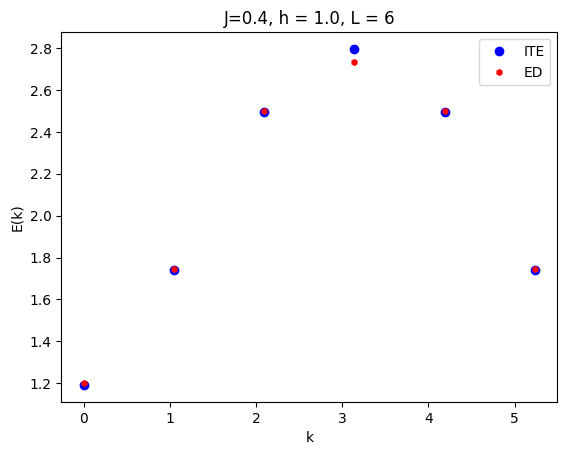

In [ ]:
plt.plot(2*np.pi*np.arange(Nqubits-1)/(Nqubits-1), dispersion,'bo',label = "ITE")
plt.plot(2*np.pi*np.arange(Nqubits-1)/(Nqubits-1), gap,'rh',label = "ED", markersize = 4)
plt.legend()
plt.ylabel("E(k)")
plt.xlabel("k")
plt.title("J=0.4, h = 1.0, L = 6")
plt.savefig("Dispersion_relation.pdf")

Here we have obtained the dispersion relation for Ising model with 6 spins.